In [0]:
#  Recurrent Neural Networks

# Here we develop RNN programs for sequence data processing

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Then of course we will need TensorFlow:

In [0]:
import tensorflow as tf

# Basic RNNs

## Manual RNN

In [0]:
# lets build an RNN with two time steps, taking input vectors of size 3 at each step.
#No of neurons in each cell is 5.

In [0]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [0]:
# This network looks much like a two-layer feedforward neural network, with a few twists: first, the same
#weights and bias terms are shared by both layers, and second, we feed inputs at each layer, and we get
#outputs from each layer.

In [0]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [137]:
print(Y0_val)

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.71978897 -0.9965762   0.9673924  -0.9998972 ]
 [ 0.99999785 -0.99898815 -0.9999989   0.9967762  -0.9999998 ]
 [ 1.         -1.         -1.         -0.9981893   0.9995087 ]]


In [138]:
print(Y1_val)

[[ 1.         -1.         -1.          0.40200275 -0.9999998 ]
 [-0.12210425  0.6280529   0.9671843  -0.9937122  -0.25839356]
 [ 0.9999982  -0.9999994  -0.9999975  -0.85943305 -0.9999879 ]
 [ 0.99928284 -0.99999803 -0.9999058   0.98579615 -0.9220575 ]]


## Using `static_rnn()`

In [0]:
# Create an RNN of a certain time step length.

In [0]:
n_inputs = 3
n_neurons = 5

In [0]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

In [0]:
init = tf.global_variables_initializer()

In [0]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [144]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.65428466, -0.9385059 ,  0.52089024],
       [ 0.99122757, -0.95425403, -0.75180787, -0.9995208 ,  0.9820235 ],
       [ 0.9999268 , -0.99783254, -0.8247353 , -0.9999963 ,  0.9994779 ],
       [ 0.996771  , -0.68750614,  0.8419969 ,  0.93039113,  0.81206834]],
      dtype=float32)

In [145]:
Y1_val

array([[ 0.999989  , -0.99976057, -0.0667929 , -0.9999803 ,  0.99982214],
       [-0.6524943 , -0.51520866, -0.37968946, -0.59225935, -0.08968391],
       [ 0.99862397, -0.99715203, -0.03308637, -0.9991566 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.3966063 , -0.83076054,  0.7967197 ]],
      dtype=float32)

In [0]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [147]:
show_graph(tf.get_default_graph())

## Packing sequences

In [0]:
# If there were 50 time steps, it would not be very convenient to have to define 50 input placeholders and
# 50 output tensors that would be needed in the above code. Moreover, at execution time you would have to feed each of the 50 placeholders and
# manipulate the 50 outputs. Let’s simplify this. The following code builds the same RNN again, but this
# time it takes a single input placeholder of shape [None, n_steps, n_inputs] where the first dimension
# is the mini-batch size.

In [0]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.static_rnn(basic_cell, X_seqs,
                                                dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [0]:
init = tf.global_variables_initializer()

In [0]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [153]:
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.94288    -0.999887    0.9405581   0.9999984  -0.9999998 ]]

 [[-0.80015343 -0.9921827   0.78177965  0.9971032  -0.9964609 ]
  [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]]

 [[-0.93605185 -0.9998379   0.9308867   0.9999814  -0.9999831 ]
  [-0.9165386  -0.9945605   0.896054    0.99987197 -0.9999751 ]]

 [[ 0.9927367  -0.9981933  -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746338 -0.7319198   0.7827872   0.9525681  -0.978177  ]]]


In [154]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.94288    -0.999887    0.9405581   0.9999984  -0.9999998 ]
 [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]
 [-0.9165386  -0.9945605   0.896054    0.99987197 -0.9999751 ]
 [-0.02746338 -0.7319198   0.7827872   0.9525681  -0.978177  ]]


## Using `dynamic_rnn()`

In [0]:
# However, this approach still builds a graph containing one cell per time step. If there were 50 time steps,
# the graph would look pretty ugly. It is a bit like writing a program without ever using loops (e.g., Y0=f(0,
# X0); Y1=f(Y0, X1); Y2=f(Y1, X2); ...; Y50=f(Y49, X50)). With such as large graph, you may
# even get out-of-memory (OOM) errors during backpropagation (especially with the limited memory of
# GPU cards), since it must store all tensor values during the forward pass so it can use them to compute
# gradients during the reverse pass.
# Fortunately, there is a better solution: the dynamic_rnn() function.

# The dynamic_rnn() function uses a while_loop() operation to run over the cell the appropriate number
# of times, and you can set swap_memory=True if you want it to swap the GPU’s memory to the CPU’s
# memory during backpropagation to avoid OOM errors. Conveniently, it also accepts a single tensor for all
# inputs at every time step (shape [None, n_steps, n_inputs]) and it outputs a single tensor for all
# outputs at every time step (shape [None, n_steps, n_neurons]); there is no need to stack, unstack, or
# transpose. The following code creates the same RNN as earlier using the dynamic_rnn() function. It’s so
# much nicer!

In [0]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [0]:
init = tf.global_variables_initializer()

In [0]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [160]:
print(outputs_val)

[[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.9999959   0.9999958   0.9981815   1.          0.37679607]]

 [[-0.9983293   0.9992038   0.98071444  0.999985    0.25192663]
  [-0.7081804  -0.07723374 -0.8522789   0.5845349  -0.78780943]]

 [[-0.9999826   0.99999535  0.9992863   1.          0.5159072 ]
  [-0.9993955   0.99840957  0.83422637  0.99999976 -0.47325206]]

 [[ 0.8788859   0.07356028  0.97216916  0.9998546  -0.7351168 ]
  [-0.91345143  0.36009565  0.7624866   0.99817705  0.80142   ]]]


In [161]:
show_graph(tf.get_default_graph())

## Setting the sequence lengths

In [0]:
# So far we had fixed length sequences (precisely 2 time steps actually)
# now lets see how to handle variable length sequences

In [0]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

In [0]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

In [0]:
init = tf.global_variables_initializer()

In [0]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [0]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [168]:
print(outputs_val)

[[[-0.9123188   0.16516446  0.5548655  -0.39159346  0.20846416]
  [-1.          0.95672596  0.99831694  0.99970174  0.96518576]]

 [[-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.9999998   0.8967998   0.9986295   0.9647514   0.93661994]
  [-0.9999526   0.96819544  0.9600285   0.98706263  0.85459226]]

 [[-0.96435434  0.995016   -0.36150697  0.9983377   0.99949706]
  [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]]


In [169]:
print(states_val)

[[-1.          0.95672596  0.99831694  0.99970174  0.96518576]
 [-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
 [-0.9999526   0.96819544  0.9600285   0.98706263  0.85459226]
 [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]


## Training a sequence classifier

In [0]:
# train an RNN to classify MNIST images. Normally CNNs are better for this task, but we try with RNN here.
# connect a fully connected softmax layer after last time step.

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.

In [0]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [172]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [173]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.93333334 Test accuracy: 0.9311
1 Train accuracy: 0.96666664 Test accuracy: 0.9522
2 Train accuracy: 0.97333336 Test accuracy: 0.9579
3 Train accuracy: 0.96 Test accuracy: 0.9637
4 Train accuracy: 0.96 Test accuracy: 0.9634
5 Train accuracy: 0.9866667 Test accuracy: 0.9698
6 Train accuracy: 0.98 Test accuracy: 0.9709
7 Train accuracy: 0.9866667 Test accuracy: 0.9689
8 Train accuracy: 0.9266667 Test accuracy: 0.9584
9 Train accuracy: 0.97333336 Test accuracy: 0.9679


# Multi-layer RNN

In [0]:
# Lets train a Deep RNN with 3 layers. Use it to train an MNIST classifier.

In [0]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [0]:
n_neurons = 100
n_layers = 3

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu)
          for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [0]:
states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [178]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.94666666 Test accuracy: 0.9516
1 Train accuracy: 0.98 Test accuracy: 0.9678
2 Train accuracy: 0.99333334 Test accuracy: 0.9654
3 Train accuracy: 0.99333334 Test accuracy: 0.975
4 Train accuracy: 0.99333334 Test accuracy: 0.9732
5 Train accuracy: 0.9866667 Test accuracy: 0.9747
6 Train accuracy: 0.9866667 Test accuracy: 0.9812
7 Train accuracy: 0.99333334 Test accuracy: 0.9828
8 Train accuracy: 0.9866667 Test accuracy: 0.981
9 Train accuracy: 0.97333336 Test accuracy: 0.9799


# Time series

In [0]:
# we will train an RNN to predict the next value in a generated time
#series. Each training instance is a randomly selected sequence of 20 consecutive values from the time
#series, and the target sequence is the same as the input sequence, except it is shifted by one time step into
#the future

In [0]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

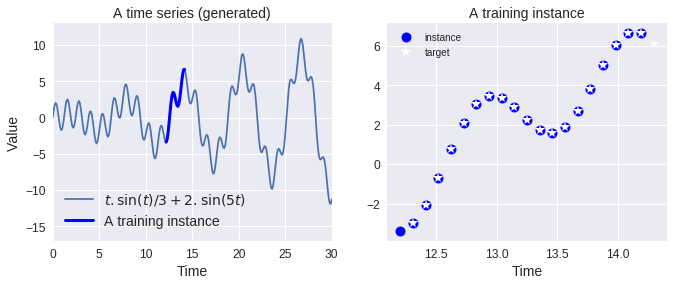

In [181]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


#save_fig("time_series_plot")
plt.show()

In [0]:
X_batch, y_batch = next_batch(1, n_steps)

In [183]:
np.c_[X_batch[0], y_batch[0]]

array([[ 1.38452097,  2.05081182],
       [ 2.05081182,  2.29742291],
       [ 2.29742291,  2.0465599 ],
       [ 2.0465599 ,  1.34009916],
       [ 1.34009916,  0.32948704],
       [ 0.32948704, -0.76115235],
       [-0.76115235, -1.68967022],
       [-1.68967022, -2.25492776],
       [-2.25492776, -2.34576159],
       [-2.34576159, -1.96789418],
       [-1.96789418, -1.24220428],
       [-1.24220428, -0.37478448],
       [-0.37478448,  0.39387907],
       [ 0.39387907,  0.84815766],
       [ 0.84815766,  0.85045064],
       [ 0.85045064,  0.3752526 ],
       [ 0.3752526 , -0.48422846],
       [-0.48422846, -1.53852738],
       [-1.53852738, -2.54795941],
       [-2.54795941, -3.28097239]])

## Using an `OuputProjectionWrapper`

Let's create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each traiing instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a sigle value:

In [0]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an `OutputProjectionWrapper`.

In [0]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [0]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [0]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [0]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [0]:
saver = tf.train.Saver()

In [190]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the content

0 	MSE: 10.261381
100 	MSE: 0.3878355
200 	MSE: 0.10966488
300 	MSE: 0.061270423
400 	MSE: 0.059311774
500 	MSE: 0.058395352
600 	MSE: 0.052744664
700 	MSE: 0.04681839
800 	MSE: 0.04907411
900 	MSE: 0.04746607
1000 	MSE: 0.04809501
1100 	MSE: 0.04658978
1200 	MSE: 0.040305413
1300 	MSE: 0.04629505
1400 	MSE: 0.041151095


In [191]:
with tf.Session() as sess:                          # not shown in the content
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [192]:
y_pred

array([[[-3.398846  ],
        [-2.4613895 ],
        [-1.0388465 ],
        [ 0.71361154],
        [ 2.2155683 ],
        [ 3.183151  ],
        [ 3.504646  ],
        [ 3.3894632 ],
        [ 2.8677046 ],
        [ 2.263647  ],
        [ 1.7114354 ],
        [ 1.5507016 ],
        [ 1.9341105 ],
        [ 2.7946086 ],
        [ 3.8872342 ],
        [ 5.1363673 ],
        [ 6.125509  ],
        [ 6.6716785 ],
        [ 6.6966453 ],
        [ 6.1055956 ]]], dtype=float32)

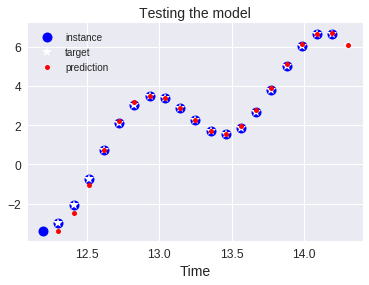

In [193]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

#save_fig("time_series_pred_plot")
plt.show()

# Deep RNN: MultiRNNCell

In [0]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [0]:
n_neurons = 100
n_layers = 3

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [0]:
init = tf.global_variables_initializer()

In [0]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [0]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [199]:
outputs_val.shape

(2, 5, 100)